### Mouting the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Setting path and Hyper paraeter

In [ ]:
#path
path = '/rcnn'
xml_train_path = path+"/pascal_bicycle_final/train_xml"
img_train_path = path+"/pascal_bicycle_final/train_jpg"

img_test_path=path+"/pascal_bicycle_final/test_jpg"
xml_test_path=path+"/pascal_bicycle_final/test_xml"
xml_pred_path =path+"/pascal_bicycle_final/pred_txt/"


#dataset 
#repracing the "bicycle" to "stopsign"
dataset_class=["aeroplane","stopsign", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]


#coloer for visualization
colors = ((0,0,0),(255,0,0),(0,255,0),(0,0,255),(100,100,100),(50,50,50),(255,255,0),(255,0,255),(0,255,255),(100,100,0),(0,100,100))

#hyper paramater
epochs=64 #tuning
batch_size=16
scale=360 #image scale

### loading data

In [ ]:
import numpy as np
import pandas as pd
 
from PIL import Image
from glob import glob
import xml.etree.ElementTree as ET 
import cv2
 
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import TensorDataset
import os


class xml_to_list(object):
    
    def __init__(self, classes):
        self.classes = classes
        
    def __call__(self, path_xml):
        
        ret = []
        xml = ET.parse(path_xml).getroot()
        
        boxes = []
        labels = []
        num=0
        
        for num,obj in enumerate(xml.iter('object')):
            
            label = obj.find('name').text
          
            ## specific class

            if label in self.classes :
                bndbox = obj.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(self.classes.index(label))
            else:
                continue
            
        num_objs = num +1

        anno = {'bboxes':boxes, 'labels':labels}

        return anno,num_objs

### making torch dataset

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    
        def __init__(self,image_dir,xml_paths,scale,classes):
            
            super().__init__()
            self.image_dir = image_dir
            self.xml_paths = xml_paths
            self.image_ids = sorted(glob('{}/*'.format(xml_paths)))
            self.scale=scale
            self.classes=classes
            
        def __getitem__(self, index):
    
            transform = transforms.Compose([
                                            transforms.ToTensor()
            ])
    
            # loading inpur data
            image_id=self.image_ids[index].split("/")[-1].split(".")[0]
            image = Image.open(f"{self.image_dir}/{image_id}.jpg")
            
            
            #changing the image scale
            t_scale_tate=self.scale 
            
            ratio=t_scale_tate/image.size[1]
            
            t_scale_yoko=image.size[0]*ratio
            t_scale_yoko=int(t_scale_yoko)
            
            #resize
            image = image.resize((t_scale_yoko,t_scale_tate))
  
            image = transform(image)
        
            transform_anno = xml_to_list(self.classes)
            path_xml=f'{self.xml_paths}/{image_id}.xml'
            
            annotations,obje_num= transform_anno(path_xml)

            boxes = torch.as_tensor(annotations['bboxes'], dtype=torch.int64)
            labels = torch.as_tensor(annotations['labels'], dtype=torch.int64)

            #resize bbox
            boxes=boxes*ratio
        
            area = (boxes[:, 3]-boxes[:, 1]) * (boxes[:, 2]-boxes[:, 0])
            area = torch.as_tensor(area, dtype=torch.float32)

            iscrowd = torch.zeros((obje_num,), dtype=torch.int64)

            target = {}
            target["boxes"] = boxes
            target["labels"] = labels+1
            target["image_id"] = torch.tensor([index])
            target["area"] = area
            target["iscrowd"] = iscrowd
            return image, target,image_id
        
        def __len__(self):

            return len(self.image_ids)

### Dataloader

In [ ]:
def dataloader (path_data,dataset_class,batch_size,scale):
    xml_paths=path_data[0]
    image_dir1=path_data[1]
    dataset = MyDataset(image_dir1,xml_paths,scale,dataset_class)

    #loading data
    torch.manual_seed(2020)
    def collate_fn(batch):
        return tuple(zip(*batch))

    train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True,collate_fn=collate_fn)
    
    return train_dataloader

### setting model

In [ ]:
def model ():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    num_classes=len(dataset_class)+1
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

### Training

In [ ]:
data_path = [xml_train_path, img_train_path]
train_dataloader=dataloader(data_path, dataset_class, batch_size, scale)

model=model()
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = epochs



device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 

model.cuda()

model.train()

loss_list=[]
for epoch in range(num_epochs):
    loss_epo=[]

    for i, batch in enumerate(train_dataloader):
        
        images, targets, image_ids = batch
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict= model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        loss_epo.append(loss_value)
 
        if (i+1) % 10== 0:
          print(f"epoch #{epoch+1} Iteration #{i+1} loss: {loss_value}") 
          
    loss_list.append(np.mean(loss_epo))
    torch.save(model, path+'/model.pt')

Streaming output truncated to the last 5000 lines.
epoch #3 Iteration #1690 loss: 0.12216386944055557
epoch #3 Iteration #1700 loss: 0.22678841650485992
epoch #3 Iteration #1710 loss: 0.2518467605113983
epoch #3 Iteration #1720 loss: 1.1147549152374268
epoch #3 Iteration #1730 loss: 0.5326206088066101
epoch #3 Iteration #1740 loss: 0.20855504274368286
epoch #3 Iteration #1750 loss: 0.711054265499115
epoch #3 Iteration #1760 loss: 0.7789311408996582
epoch #3 Iteration #1770 loss: 0.19744440913200378
epoch #3 Iteration #1780 loss: 0.2064152956008911
epoch #3 Iteration #1790 loss: 0.8651880621910095
epoch #3 Iteration #1800 loss: 0.18913695216178894
epoch #3 Iteration #1810 loss: 0.08679667115211487
epoch #3 Iteration #1820 loss: 0.3457362949848175
epoch #3 Iteration #1830 loss: 0.12132395803928375
epoch #3 Iteration #1840 loss: 0.14468996226787567
epoch #3 Iteration #1850 loss: 0.24209138751029968
epoch #3 Iteration #1860 loss: 0.5397297143936157
epoch #3 Iteration #1870 loss: 0.13268330

### Test

In [ ]:
import cv2
import glob
import matplotlib.pyplot as plt

data_class = dataset_class
data_class.insert(0, "__background__")
classes = tuple(data_class)

model=torch.load(path + '/pascal_bicycle_final/model.pt')

### Visualization

/content/drive/MyDrive/浙江大学/rcnn/pascal_bicycle_final/test_jpg/004214.jpg


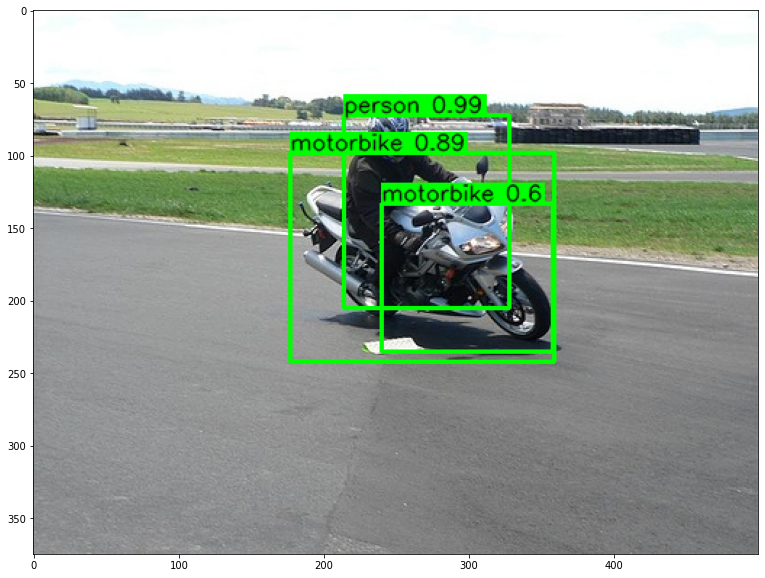

/content/drive/MyDrive/浙江大学/rcnn/pascal_bicycle_final/test_jpg/002118.jpg


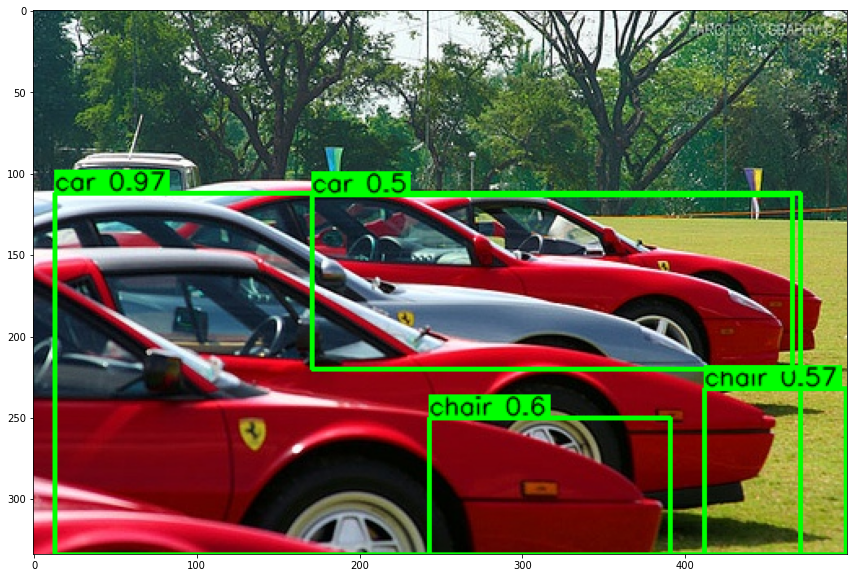

/content/drive/MyDrive/浙江大学/rcnn/pascal_bicycle_final/test_jpg/007817.jpg


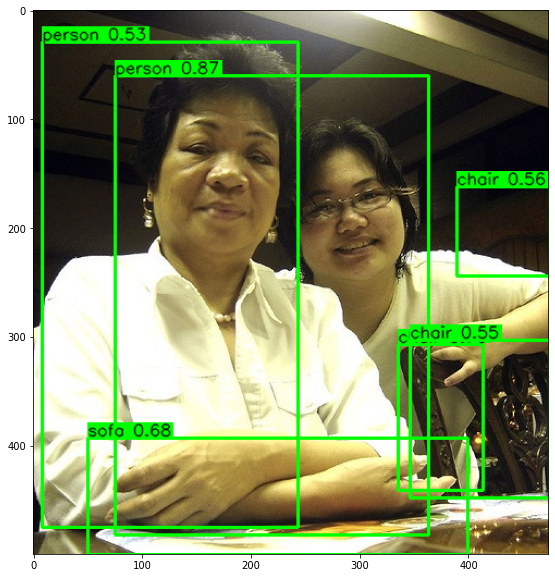

In [ ]:
import random

model.to(device)

model.eval()

for imgfile in random.sample(sorted(glob.glob(img_test_path+'/*')), 3):
    
    img = cv2.imread(imgfile)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image_tensor = torchvision.transforms.functional.to_tensor(img)

    with torch.no_grad():
        prediction = model([image_tensor.to(device)])
    
    for i,box in enumerate(prediction[0]['boxes']):
        score = prediction[0]['scores'][i].cpu().numpy()
        if score > 0.5:
            score = round(float(score),2)
            cat = prediction[0]['labels'][i].cpu().numpy()
            txt = '{} {}'.format(classes[int(cat)], str(score))
            font = cv2.FONT_HERSHEY_SIMPLEX
            cat_size = cv2.getTextSize(txt, font, 0.5, 2)[0]
            c = colors[2]
            box=box.cpu().numpy().astype('int')
            cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), c , 2)
            cv2.rectangle(img,(box[0], box[1] - cat_size[1] - 2),(box[0] + cat_size[0], box[1] - 2), c, -1)
            cv2.putText(img, txt, (box[0], box[1] - 2), font, 0.5, (0, 0, 0), thickness=1, lineType=cv2.LINE_AA)

    plt.figure(figsize=(15,10))
    plt.imshow(img)
    print(imgfile)
    plt.show()

### downloading the prediction result

In [ ]:
model.to(device)

model.eval()

for imgfile in sorted(glob.glob(img_test_path + '/*')):
    
    img = cv2.imread(imgfile)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image_tensor = torchvision.transforms.functional.to_tensor(img)

    out_txt_list = []
    with torch.no_grad():
        prediction = model([image_tensor.to(device)])
    
    for i,box in enumerate(prediction[0]['boxes']):
        score = prediction[0]['scores'][i].cpu().numpy()

        if score > 0.5:
            score = round(float(score),2)
            cat = prediction[0]['labels'][i].cpu().numpy()
            txt = '{} {}'.format(classes[int(cat)], str(score))
            obj_info_string = txt + " " + str(int(box[0].item())) + " " + str(int(box[1].item())) + " " + str(int(box[2].item())) + " " + str(int(box[3].item()))
            out_txt_list.append(obj_info_string)
    print(out_txt_list)
    print(imgfile.split("/")[-1][:-4])
    out_txt_file_path = os.path.join(xml_pred_path, imgfile.split("/")[-1][:-4]+".txt")

    with open(out_txt_file_path, mode="w") as f:
        f.write("\n".join(out_txt_list))